# CNN Explaination

[作業說明投影片](https://docs.google.com/presentation/d/1VClvgyilAvohextY0tM3gD7YemXGSUrzLV0E8RjDnMU/edit?usp=sharing)

如果有自己的計算資源，不想使用 colab 的話，可以參考純 [Python script](https://github.com/leo19941227/MLHW4-Explainable) 的版本

若有任何問題，歡迎來信至助教信箱： ntu-ml-2020spring-ta@googlegroups.com

## Environment settings

In [17]:
# 下載並解壓縮訓練資料
!gdown --id '19CzXudqN58R3D-1G8KeFWk8UDQwlb8is' --output food-11.zip
!unzip -o food-11.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: food-11/training/8_427.jpg  
  inflating: food-11/training/2_849.jpg  
  inflating: food-11/training/4_165.jpg  
  inflating: food-11/training/5_376.jpg  
  inflating: food-11/training/2_691.jpg  
  inflating: food-11/training/0_541.jpg  
  inflating: food-11/training/3_482.jpg  
  inflating: food-11/training/0_227.jpg  
  inflating: food-11/training/5_410.jpg  
  inflating: food-11/training/4_603.jpg  
  inflating: food-11/training/8_341.jpg  
  inflating: food-11/training/5_1154.jpg  
  inflating: food-11/training/9_37.jpg  
  inflating: food-11/training/9_152.jpg  
  inflating: food-11/training/5_438.jpg  
  inflating: food-11/training/9_1287.jpg  
  inflating: food-11/training/8_369.jpg  
  inflating: food-11/training/2_1455.jpg  
  inflating: food-11/training/10_247.jpg  
  inflating: food-11/training/7_32.jpg  
  inflating: food-11/training/10_521.jpg  
  inflating: food-11/training/2_1333.jpg  
  inflating: food-11/training/2_861.jpg  
  inflati

In [18]:
# 下載 pretrained model，這裡是用助教的 model demo，寫作業時要換成自己的 model
# !gdown --id '1CShZHsO8oAZwxQkMe7jRtEgSNb2w_OZu' --output checkpoint.pth
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# 安裝lime套件
# 這份作業會用到的套件大部分 colab 都有安裝了，只有 lime 需要額外安裝
!pip install lime==0.1.1.37

## Start our python script

In [20]:
import os
import sys
import argparse
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import Dataset
import torchvision.transforms as transforms
from skimage.segmentation import slic
from lime import lime_image
from pdb import set_trace

## Argument parsing

In [21]:
args = {
      'ckptpath': '/content/drive/MyDrive/model_best.pth',
      'dataset_dir': './food-11/'
}
args = argparse.Namespace(**args)

## Model definition and checkpoint loading

In [22]:
# 這是助教的示範 model，寫作業時一樣要換成自己的
# 已更換
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [512, 8, 8]

            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [512, 4, 4]

            nn.Conv2d(512, 512, 3, 1, 1), # [512, 4, 4]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [512, 2, 2]

            nn.Conv2d(512, 512, 3, 1, 1), # [512, 2, 2]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0)       # [512, 1, 1]
        )
        self.fc = nn.Sequential(
            nn.Linear(512*1*1, 11)
        )

    def forward(self, x):
        out = self.cnn(x)
        out = out.view(out.size()[0], -1)
        return self.fc(out)

In [23]:
model = Classifier().cuda()
checkpoint = torch.load(args.ckptpath)
# 模型儲存方式不同，更改 checkpoint 結構
model.load_state_dict(checkpoint)
# 基本上出現 <All keys matched successfully> 就是有載入成功，但最好還是做一下 inference 確認 test accuracy 沒有錯。

<All keys matched successfully>

## Dataset definition and creation

In [24]:
# 助教 training 時定義的 dataset
# 因為 training 的時候助教有使用底下那些 transforms，所以 testing 時也要讓 test data 使用同樣的 transform
# dataset 這部分的 code 基本上不應該出現在你的作業裡，你應該使用自己當初 train HW3 時的 preprocessing
# 已更換
class FoodDataset(Dataset):
    def __init__(self, paths, labels, mode):
        # mode: 'train' or 'eval'

        self.paths = paths
        self.labels = labels
        trainTransform = transforms.Compose([
            transforms.Resize(size=(128, 128)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
        ])
        evalTransform = transforms.Compose([
            transforms.Resize(size=(128, 128)),
            transforms.ToTensor(),
        ])
        self.transform = trainTransform if mode == 'train' else evalTransform

    # 這個 FoodDataset 繼承了 pytorch 的 Dataset class
    # 而 __len__ 和 __getitem__ 是定義一個 pytorch dataset 時一定要 implement 的兩個 methods
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        X = Image.open(self.paths[index])
        X = self.transform(X)
        Y = self.labels[index]
        return X, Y

    # 這個 method 並不是 pytorch dataset 必要，只是方便未來我們想要指定「取哪幾張圖片」出來當作一個 batch 來 visualize
    def getbatch(self, indices):
        images = []
        labels = []
        for index in indices:
          image, label = self.__getitem__(index)
          images.append(image)
          labels.append(label)
        return torch.stack(images), torch.tensor(labels)

# 給予 data 的路徑，回傳每一張圖片的「路徑」和「class」
def get_paths_labels(path):
    imgnames = os.listdir(path)
    imgnames.sort()
    imgpaths = []
    labels = []
    for name in imgnames:
        imgpaths.append(os.path.join(path, name))
        labels.append(int(name.split('_')[0]))
    return imgpaths, labels
train_paths, train_labels = get_paths_labels(os.path.join(args.dataset_dir, 'training'))

# 這邊在 initialize dataset 時只丟「路徑」和「class」，之後要從 dataset 取資料時
# dataset 的 __getitem__ method 才會動態的去 load 每個路徑對應的圖片
train_set = FoodDataset(train_paths, train_labels, mode='eval')

## Start Homework 4

### Saliency map

我們把一張圖片丟進 model，forward 後與 label 計算出 loss。
因此與 loss 相關的有:
- image
- model parameter
- label

通常的情況下，我們想要改變 model parameter 來 fit image 和 label。因此 loss 在計算 backward 時我們只在乎 **loss 對 model parameter** 的偏微分值。但數學上 image 本身也是 continuous tensor，我們可以計算  **loss 對 image** 的偏微分值。這個偏微分值代表「在 model parameter 和 label 都固定下，稍微改變 image 的某個 pixel value 會對 loss 產生什麼變化」。人們習慣把這個變化的劇烈程度解讀成該 pixel 的重要性 (每個 pixel 都有自己的偏微分值)。因此把同一張圖中，loss 對每個 pixel 的偏微分值畫出來，就可以看出該圖中哪些位置是 model 在判斷時的重要依據。

實作上非常簡單，過去我們都是 forward 後算出 loss，然後進行 backward。而這個 backward，pytorch 預設是計算 **loss 對 model parameter** 的偏微分值，因此我們只需要用一行 code 額外告知 pytorch，**image** 也是要算偏微分的對象之一。

In [25]:
def normalize(image):
  return (image - image.min()) / (image.max() - image.min())

def compute_saliency_maps(x, y, model):
  model.eval()
  x = x.cuda()

  # 最關鍵的一行 code
  # 因為我們要計算 loss 對 input image 的微分，原本 input x 只是一個 tensor，預設不需要 gradient
  # 這邊我們明確的告知 pytorch 這個 input x 需要gradient，這樣我們執行 backward 後 x.grad 才會有微分的值
  x.requires_grad_()

  y_pred = model(x)
  loss_func = torch.nn.CrossEntropyLoss()
  loss = loss_func(y_pred, y.cuda())
  loss.backward()

  saliencies = x.grad.abs().detach().cpu()
  # saliencies: (batches, channels, height, weight)
  # 因為接下來我們要對每張圖片畫 saliency map，每張圖片的 gradient scale 很可能有巨大落差
  # 可能第一張圖片的 gradient 在 100 ~ 1000，但第二張圖片的 gradient 在 0.001 ~ 0.0001
  # 如果我們用同樣的色階去畫每一張 saliency 的話，第一張可能就全部都很亮，第二張就全部都很暗，
  # 如此就看不到有意義的結果，我們想看的是「單一張 saliency 內部的大小關係」，
  # 所以這邊我們要對每張 saliency 各自做 normalize。手法有很多種，這邊只採用最簡單的
  saliencies = torch.stack([normalize(item) for item in saliencies])
  return saliencies

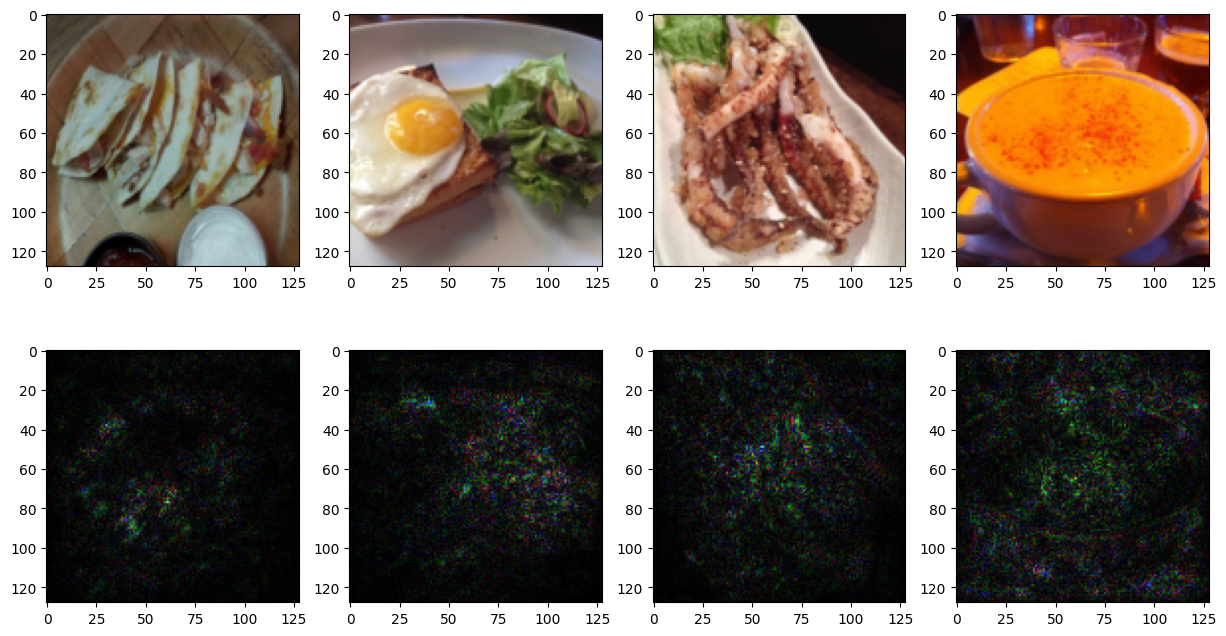

In [26]:
# 指定想要一起 visualize 的圖片 indices
img_indices = [83, 4218, 4707, 8598]
images, labels = train_set.getbatch(img_indices)
saliencies = compute_saliency_maps(images, labels, model)

# 使用 matplotlib 畫出來
fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
for row, target in enumerate([images, saliencies]):
  for column, img in enumerate(target):
    axs[row][column].imshow(img.permute(1, 2, 0).numpy())
    # 小知識：permute 是什麼，為什麼這邊要用?
    # 在 pytorch 的世界，image tensor 各 dimension 的意義通常為 (channels, height, width)
    # 但在 matplolib 的世界，想要把一個 tensor 畫出來，形狀必須為 (height, width, channels)
    # 因此 permute 是一個 pytorch 很方便的工具來做 dimension 間的轉換
    # 這邊 img.permute(1, 2, 0)，代表轉換後的 tensor，其
    # - 第 0 個 dimension 為原本 img 的第 1 個 dimension，也就是 height
    # - 第 1 個 dimension 為原本 img 的第 2 個 dimension，也就是 width
    # - 第 2 個 dimension 為原本 img 的第 0 個 dimension，也就是 channels

plt.show()
plt.close()
# 從第二張圖片的 saliency，我們可以發現 model 有認出蛋黃的位置
# 從第三、四張圖片的 saliency，雖然不知道 model 細部用食物的哪個位置判斷，但可以發現 model 找出了食物的大致輪廓

## Filter explaination

這裡我們想要知道某一個 filter 到底認出了什麼。我們會做以下兩件事情：
- Filter activation: 挑幾張圖片出來，看看圖片中哪些位置會 activate 該 filter
- Filter visualization: 怎樣的 image 可以最大程度的 activate 該 filter

實作上比較困難的地方是，通常我們是直接把 image 丟進 model，一路 forward 到底。如：
```
loss = model(image)
loss.backward()
```
我們要怎麼得到中間某層 CNN 的 output? 當然我們可以直接修改 model definition，讓 forward 不只 return loss，也 return activation map。但這樣的寫法麻煩了，更改了 forward 的 output 可能會讓其他部分的 code 要跟著改動。因此 pytorch 提供了方便的 solution: **hook**，以下我們會再介紹。

In [27]:
model

Classifier(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [28]:
def normalize(image):
  return (image - image.min()) / (image.max() - image.min())

layer_activations = None
def filter_explaination(x, model, cnnid, filterid, iteration=100, lr=1):
  # x: 要用來觀察哪些位置可以 activate 被指定 filter 的圖片們
  # cnnid, filterid: 想要指定第幾層 cnn 中第幾個 filter
  model.eval()

  def hook(model, input, output):
    global layer_activations
    layer_activations = output

  hook_handle = model.cnn[cnnid].register_forward_hook(hook)
  # 這一行是在告訴 pytorch，當 forward 「過了」第 cnnid 層 cnn 後，要先呼叫 hook 這個我們定義的 function 後才可以繼續 forward 下一層 cnn
  # 因此上面的 hook function 中，我們就會把該層的 output，也就是 activation map 記錄下來，這樣 forward 完整個 model 後我們就不只有 loss
  # 也有某層 cnn 的 activation map
  # 注意：到這行為止，都還沒有發生任何 forward。我們只是先告訴 pytorch 等下真的要 forward 時該多做什麼事
  # 注意：hook_handle 可以先跳過不用懂，等下看到後面就有說明了

  # Filter activation: 我們先觀察 x 經過被指定 filter 的 activation map
  model(x.cuda())
  # 這行才是正式執行 forward，因為我們只在意 activation map，所以這邊不需要把 loss 存起來
  filter_activations = layer_activations[:, filterid, :, :].detach().cpu()

  # 根據 function argument 指定的 filterid 把特定 filter 的 activation map 取出來
  # 因為目前這個 activation map 我們只是要把他畫出來，所以可以直接 detach from graph 並存成 cpu tensor

  # Filter visualization: 接著我們要找出可以最大程度 activate 該 filter 的圖片
  x = x.cuda()
  # 從一張 random noise 的圖片開始找 (也可以從一張 dataset image 開始找)
  x.requires_grad_()
  # 我們要對 input image 算偏微分
  optimizer = Adam([x], lr=lr)
  # 利用偏微分和 optimizer，逐步修改 input image 來讓 filter activation 越來越大
  for iter in range(iteration):
    optimizer.zero_grad()
    model(x)

    objective = -layer_activations[:, filterid, :, :].sum()
    # 與上一個作業不同的是，我們並不想知道 image 的微量變化會怎樣影響 final loss
    # 我們想知道的是，image 的微量變化會怎樣影響 activation 的程度
    # 因此 objective 是 filter activation 的加總，然後加負號代表我們想要做 maximization

    objective.backward()
    # 計算 filter activation 對 input image 的偏微分
    optimizer.step()
    # 修改 input image 來最大化 filter activation
  filter_visualization = x.detach().cpu().squeeze()[0]
  # 完成圖片修改，只剩下要畫出來，因此可以直接 detach 並轉成 cpu tensor

  hook_handle.remove()
  # 很重要：一旦對 model register hook，該 hook 就一直存在。如果之後繼續 register 更多 hook
  # 那 model 一次 forward 要做的事情就越來越多，甚至其行為模式會超出你預期 (因為你忘記哪邊有用不到的 hook 了)
  # 因此事情做完了之後，就把這個 hook 拿掉，下次想要再做事時再 register 就好了。

  return filter_activations, filter_visualization

In [35]:
for i in range(0, 25, 4):
  img_indices = [83, 4218, 4707, 8598]
  images, labels = train_set.getbatch(img_indices)
  filter_activations, filter_visualization = filter_explaination(images, model, cnnid=i, filterid=0, iteration=100, lr=0.1)

  # 畫出 filter visualization
  plt.imshow(normalize(filter_visualization.permute(1, 2, 0)))
  plt.show()
  plt.close()
  # 根據圖片中的線條，可以猜測第 15 層 cnn 其第 0 個 filter 可能在認一些線條、甚至是 object boundary
  # 因此給 filter 看一堆對比強烈的線條，他會覺得有好多 boundary 可以 activate

  # 畫出 filter activations
  fig, axs = plt.subplots(2, len(img_indices), figsize=(15, 8))
  for i, img in enumerate(images):
    axs[0][i].imshow(img.permute(1, 2, 0))
  for i, img in enumerate(filter_activations):
    axs[1][i].imshow(normalize(img))
  plt.show()
  plt.close()
  # 從下面四張圖可以看到，activate 的區域對應到一些物品的邊界，尤其是顏色對比較深的邊界

Output hidden; open in https://colab.research.google.com to view.

## Lime

Lime 的部分因為有現成的套件可以使用，因此下方直接 demo 如何使用該套件。其實非常的簡單，只需要 implement 兩個 function 即可。

4


1


4


8


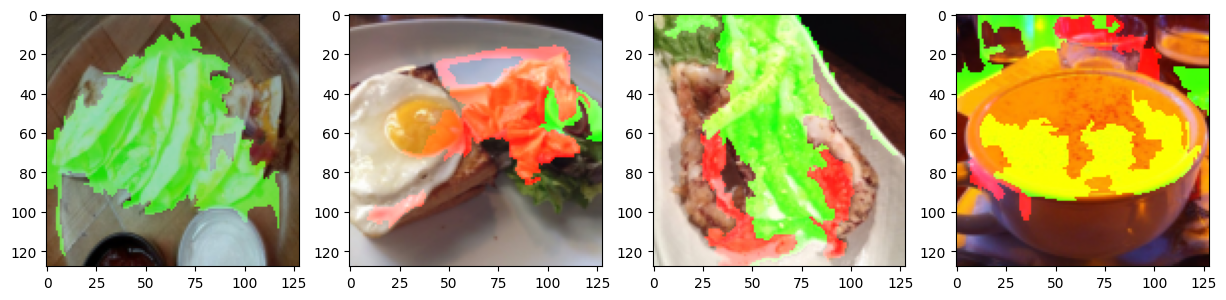

In [30]:
def predict(input):
    # input: numpy array, (batches, height, width, channels)

    model.eval()
    input = torch.FloatTensor(input).permute(0, 3, 1, 2)
    # 需要先將 input 轉成 pytorch tensor，且符合 pytorch 習慣的 dimension 定義
    # 也就是 (batches, channels, height, width)

    output = model(input.cuda())
    return output.detach().cpu().numpy()

def segmentation(input):
    # 利用 skimage 提供的 segmentation 將圖片分成 100 塊
    return slic(input, n_segments=100, compactness=1, sigma=1)

img_indices = [83, 4218, 4707, 8598]
images, labels = train_set.getbatch(img_indices)
fig, axs = plt.subplots(1, 4, figsize=(15, 8))
np.random.seed(16)
# 讓實驗 reproducible
for idx, (image, label) in enumerate(zip(images.permute(0, 2, 3, 1).numpy(), labels)):
    x = image.astype(np.double)
    # lime 這個套件要吃 numpy array
    # 已修改

    explainer = lime_image.LimeImageExplainer()
    explaination = explainer.explain_instance(image=x, classifier_fn=predict, segmentation_fn=segmentation)

    # 獲取預測標籤（或排名靠前的預測標籤之一）
    predicted_label = list(explaination.local_exp.keys())[0]  # 獲取第一個鍵（標籤）
    print(predicted_label)
    lime_img, mask = explaination.get_image_and_mask(
        label=predicted_label,  # 使用預測標籤
        positive_only=False,
        hide_rest=False,
        num_features=11,
        min_weight=0.05
    )
    # 把 explainer 解釋的結果轉成圖片
    # doc: https://lime-ml.readthedocs.io/en/latest/lime.html?highlight=get_image_and_mask#lime.lime_image.ImageExplanation.get_image_and_mask

    axs[idx].imshow(lime_img)

plt.show()
plt.close()
# 從以下前三章圖可以看到，model 有認出食物的位置，並以該位置為主要的判斷依據
# 唯一例外是第四張圖，看起來 model 似乎比較喜歡直接去認「碗」的形狀，來判斷該圖中屬於 soup 這個 class
# 至於碗中的內容物被標成紅色，代表「單看碗中」的東西反而有礙辨認。
# 當 model 只看碗中黃色的一坨圓形，而沒看到「碗」時，可能就會覺得是其他黃色圓形的食物。